# RateAndHalfSat - hourly
Nutrient comparisons with edited dataset using surface instead of 2m for depth. (

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
import os
import glob
%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Change path, start and end dats here

In [3]:
PATH = '/data/vdo/MEOPAR/completed-runs/RateAndHalfSat/'

In [4]:
start_date = datetime.datetime(2015,1,31)
end_date = datetime.datetime(2015,5,2)

In [5]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [6]:
# Load CitSci data and clean it up
nutrients_2015 = pd.read_csv(
    '/ocean/eolson/MEOPAR/obs/PSFCitSci/PSFbottledata2015_CN_edits_EOCor2.csv')
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])
nutrients_2015 = nutrients_2015.dropna(subset=['Xind'])
nutrients_2015 = nutrients_2015[~nutrients_2015.flagged]
nutrients_2015 = nutrients_2015.dropna(subset=['Time'])

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [7]:
shape = nutrients_2015.shape[0]

In [8]:
# mask everything outside of daterange of modelled results 
# apply same mask to everything in CS data
dates = nutrients_2015['date'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(shape)])
dates = np.ma.masked_outside(dates, start_date, end_date)
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)
stations = np.ma.masked_array(nutrients_2015['station'].values, mask = dates.mask)

In [9]:
np.ma.count(cs_si)

243

In [10]:
local = pytz.timezone ("America/Los_Angeles")

In [11]:
list_of_model_si = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_latitude = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_longitude = np.ma.masked_array(np.zeros((shape)), mask = True)
list_of_days = np.ma.masked_array(np.empty(shape, dtype='datetime64[s]'), mask = True)
t = 0
for n in nutrients_2015.index:
    if dates.mask[t] == False:
        Yind = Yinds[t]
        Xind = Xinds[t]
        date = (local.localize(pd.to_datetime(datetime.datetime.strptime(nutrients_2015['date'][n] 
                           +' '+ nutrients_2015['Time'][n], 
                           '%d-%m-%Y %I:%M:%S %p')), 
                   is_dst=True).astimezone(pytz.utc))
        datestr = date.strftime('%Y%m%d')
        nuts = nc.Dataset(glob.glob(PATH + '*/SalishSea*1h*ptrc_T*' + datestr +'.nc')[0])
        if nutrients_2015['depth'][n] == 2:
            depth = 0
        elif nutrients_2015['depth'][n] == 20:
            depth = 18
        if mesh.variables['tmask'][0,depth,Yind,Xind] == 1:
            if date.minute < 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                   hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
                after = before + datetime.timedelta(hours=1)
                datestr2 = after.strftime('%Y%m%d')
                nuts2 = nc.Dataset(glob.glob(PATH + '*/SalishSea*1h*ptrc_T*' + datestr2 +'.nc')[0])
                delta = (date.minute + 30) / 60
                ni_val = ((1-delta)*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                           (delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
                si_val = ((1-delta)*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                           (delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
            if date.minute >= 30:
                before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                                       hour = (date.hour), minute = 30)
                after = before + datetime.timedelta(hours=1)
                datestr2 = after.strftime('%Y%m%d')
                nuts2 = nc.Dataset(glob.glob(PATH + '*/SalishSea*1h*ptrc_T*' + datestr2 +'.nc')[0])
                delta = (date.minute) / 60
                ni_val = ((delta)*(nuts.variables['nitrate'][before.hour, depth, Yind, Xind] ) + 
                           (1-delta)*(nuts2.variables['nitrate'][after.hour, depth, Yind, Xind] ))
                si_val = ((delta)*(nuts.variables['silicon'][before.hour, depth, Yind, Xind] ) + 
                           (1-delta)*(nuts2.variables['silicon'][after.hour, depth, Yind, Xind] ))
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = si_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = ni_val
            list_of_latitude.mask[t] = False
            list_of_latitude[t] = nutrients_2015['lat'][n]
            list_of_longitude.mask[t] = False
            list_of_longitude[t] = nutrients_2015['lon'][n]
            list_of_days.mask[t] = False
            list_of_days[t] = date
    t = t + 1

In [12]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [13]:
stations = np.ma.masked_array(stations, mask = list_of_model_si.mask)

In [14]:
np.ma.count(cs_no23)

239

bias =  0.7884185145458886
RMSE = 5.8581438152912
Willmott = 0.8764940548878741


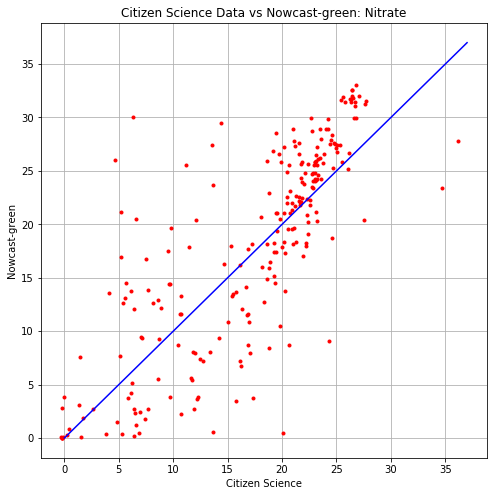

In [15]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_no23, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_no23) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_no23)**2) /
                              np.ma.count(cs_no23))))
xbar = np.mean(cs_no23)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_no23)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_no23 - xbar))**2))))

bias =  -6.375806349241593
RMSE = 16.013808950910125
Willmott = 0.722431923800329


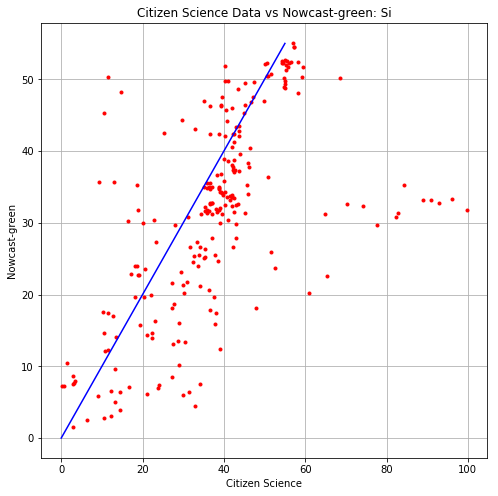

In [16]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              np.ma.count(cs_no23))))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

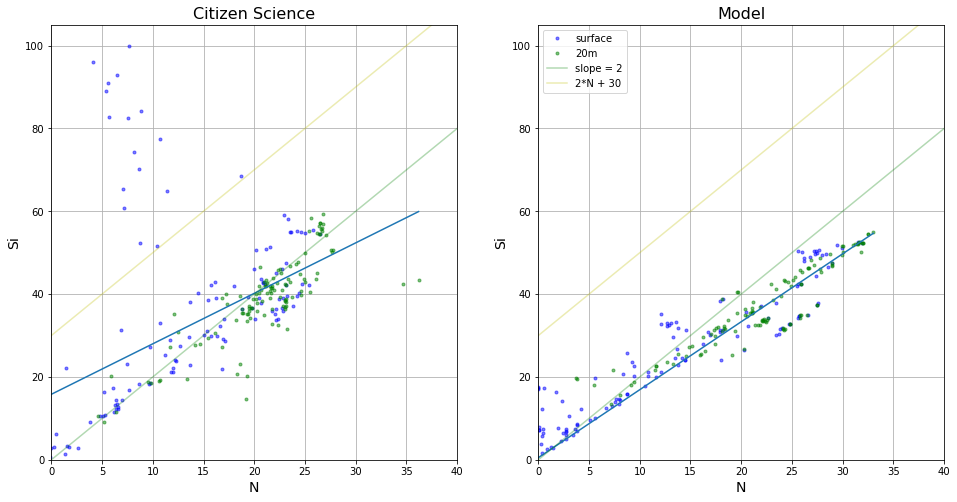

In [17]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_no23[nutrients_2015['depth'].values == 2], 
           cs_si[nutrients_2015['depth'].values == 2], 
           'b.', alpha = 0.5)
ax[0].plot(cs_no23[nutrients_2015['depth'].values == 20], 
           cs_si[nutrients_2015['depth'].values == 20], 
           'g.', alpha = 0.5)
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 2], 
           list_of_model_si[nutrients_2015['depth'].values == 2], 'b.', 
           alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 20], 
           list_of_model_si[nutrients_2015['depth'].values == 20], 'g.', 
           alpha = 0.5, label = '20m')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, 
                                list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [18]:
m1, b1 = np.polyfit(cs_no23, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.2187430117967932
CitSci y int = 15.815501339767406
model slope = 1.6405672201622854
model y int = 0.5206022370450664
